In [13]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse)
library(caret)
# library(visdat)
library(naniar)
library(mlr3)
library(mlr3learners)
# library(mlr3measures)
library(e1071)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df <- read_csv("../input/case-study/datascience_assessment_data.csv")
summary(df)
# vis_dat(df, warn_large_data=FALSE)

table(1000*df$stage_1 + 100*df$stage_2 + 10*df$stage_3 + df$stage_4)

# df1 <- drop_na(df)
df1 <- df
df1 <- mutate(df1, search_feature_4 = ifelse(search_feature_4 == "A",  1, ifelse(search_feature_4 == "C",  3, 0)))
df1 <- mutate(df1, search_feature_5 = ifelse(search_feature_5 == "A",  1, ifelse(search_feature_5 == "B",  2, 0)))

srftnames <- grep("search_feature", names(df), value = TRUE)
colnames <- grep("_feature", names(df), value = TRUE)
colnames <- colnames[-c(4:5)]
pdftnames <- grep("product_feature", names(df), value = TRUE)
for (col in colnames) {
  df1 <- df1 %>% mutate_at(col, ~(scale(., center = TRUE, scale = TRUE) %>% as.vector))
}

srft_corr <- df1[ , names(df1) %in% srftnames] %>% drop_na() %>% cor()
pdft_corr <- df1[ , names(df1) %in% pdftnames] %>% drop_na() %>% cor()
heatmap(srft_corr, Rowv=NA, symm=TRUE)
heatmap(pdft_corr, Rowv=NA, symm=TRUE)

df1 <- mutate(df1, allstages = 1000*df1$stage_1 + 100*df1$stage_2 
              + 10*df1$stage_3 + df1$stage_4)
df1 <- select(df1, -c(stage_1, stage_2, stage_3, stage_4))
for (col in names(df1)) { print(c(col, length(unique(df1[[col]])))) }

miss_var_summary(df1, order = FALSE)

set.seed(2, sample.kind = "Rounding")
sample_set <- df1 %>% drop_na %>% slice(sample(nrow(.), 200000))
sample_set <- mutate(sample_set, allstages = as.factor(allstages))
sample_set <- sample_set[,2:15] # drop 1st column, row_id
train_set <- sample_set[1:100000,]
test_set <- sample_set[100001:200000,]

wt_balance (weights, df1$allstages)

task_stages = TaskClassif$new(id = "stages", 
                  backend = sample_set,
                  target = "allstages")

train_idx = sample(task_stages$nrow, 0.8 * task_stages$nrow)
test_idx = setdiff(seq_len(task_stages$nrow), train_idx)
#
for(gamma in c(0.01,0.03,0.1,0.3,1.,3,10,30)) {
   for(cost in 2^(-5:5)) {
# for(gamma in c(0.01,0.1,1.,10)) {
#    for(cost in 2^(-2:2)) {
#    test_acc(gamma, cost, 0)
    test_acc(gamma, cost, weights, 0)
  }
}
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# function to run model with args gamma, cost as parameters
test_acc <- function (gamma = 0.1, cost=10, weights, confuse_com) {
lrnr = lrn("classif.svm", kernel="radial", type = "C-classification", 
#           class.weights=weights,
           gamma = gamma, cost=cost)
#           gamma = 0.1, cost=10)
#           cost=10)
lrnr$train(task_stages, row_ids = train_idx)
predict0 <- lrnr$predict(task_stages, row_ids = test_idx)
if (confuse_com ==1) {predict0$confusion}
print (c(gamma, cost, acc(predict0$truth, predict0$response)))
}
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# function to balance weights among outcome classes
wt_balance <- function (weights, column) {
  weights <- table(column)
  weights <- weights * length(weights) / sum(weights)
  weights <- 1./weights
# weights <- sqrt(weights) # avoid extremely large weights
}

     row_id        search_date       stage_1     stage_2         stage_3     
 Min.   :     0   Min.   : 0.00   Min.   :1   Min.   :0.00    Min.   :0.00   
 1st Qu.: 75948   1st Qu.:15.00   1st Qu.:1   1st Qu.:0.00    1st Qu.:1.00   
 Median :151896   Median :25.00   Median :1   Median :0.00    Median :1.00   
 Mean   :151896   Mean   :23.82   Mean   :1   Mean   :0.08    Mean   :0.89   
 3rd Qu.:227844   3rd Qu.:33.00   3rd Qu.:1   3rd Qu.:0.00    3rd Qu.:1.00   
 Max.   :303792   Max.   :42.00   Max.   :1   Max.   :1.00    Max.   :1.00   
                                              NA's   :44849   NA's   :44849  
    stage_4      search_feature_1 search_feature_2 search_feature_3
 Min.   :0.00    Min.   :0.00     Min.   :-18.00   Min.   :  0.00  
 1st Qu.:0.00    1st Qu.:0.00     1st Qu.: 21.00   1st Qu.: 50.00  
 Median :0.00    Median :2.00     Median : 43.00   Median : 70.00  
 Mean   :0.02    Mean   :2.21     Mean   : 67.11   Mean   : 72.22  
 3rd Qu.:0.00    3rd Qu.:4.00     3r

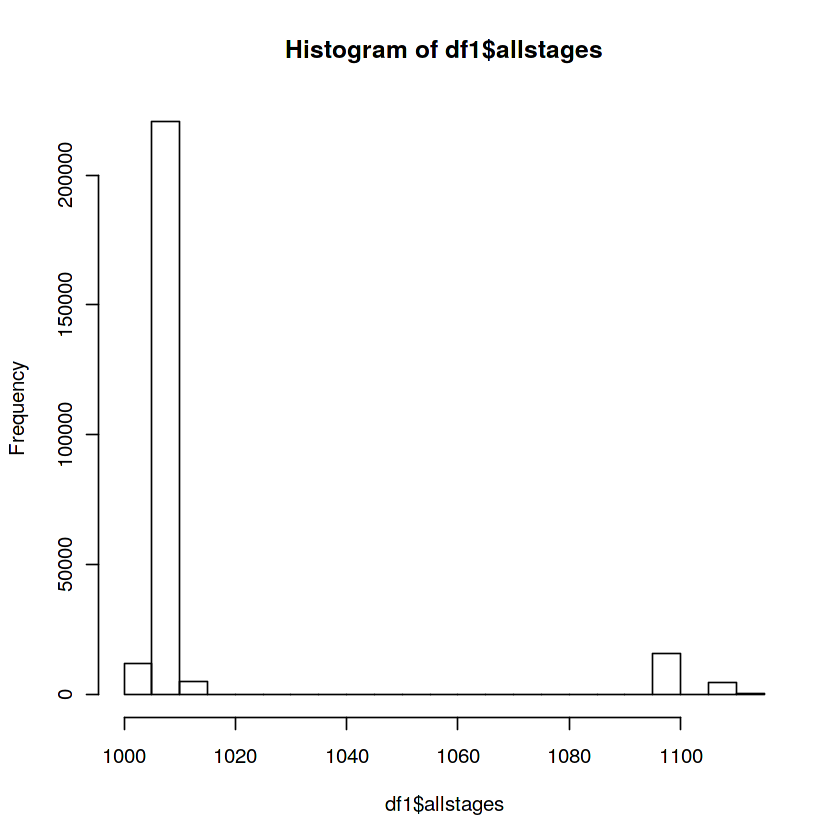

In [5]:
# test_acc(10, 8, weights, 1)

table(df1$allstages)

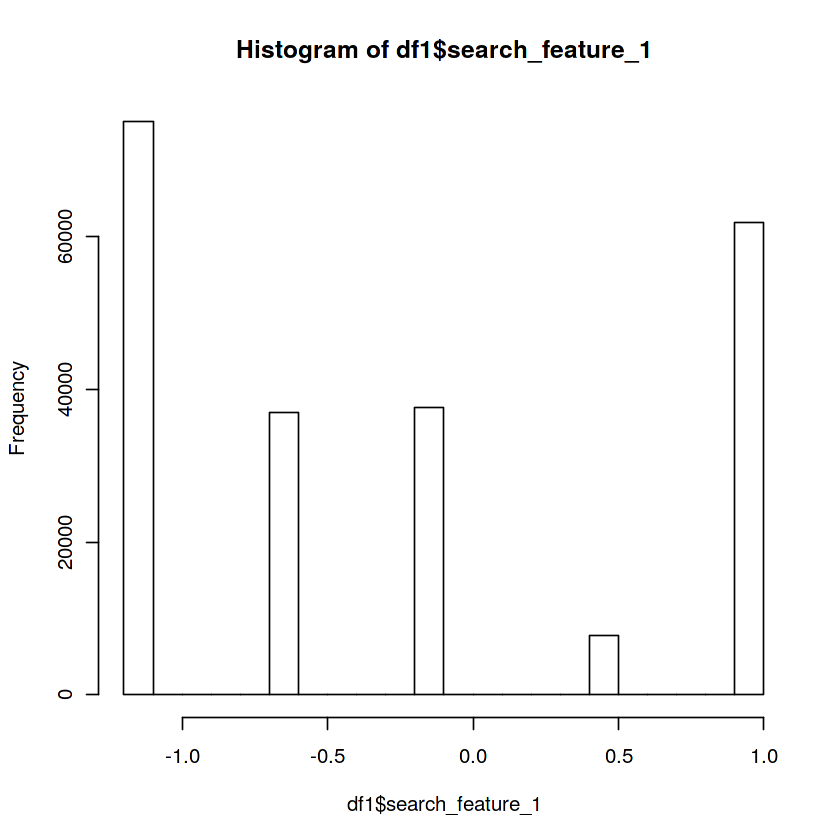

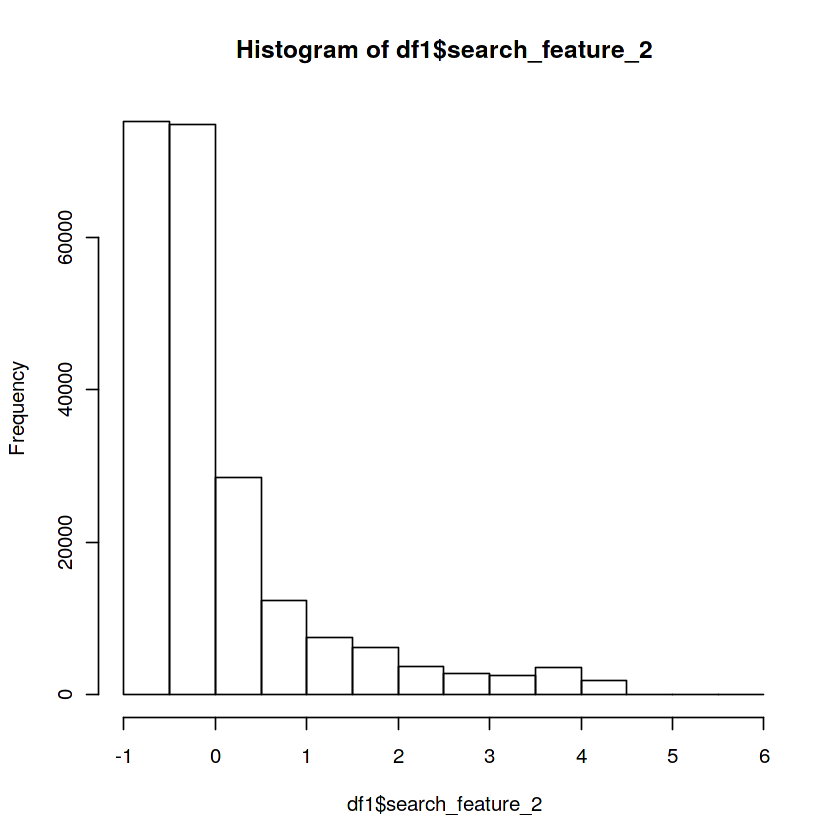

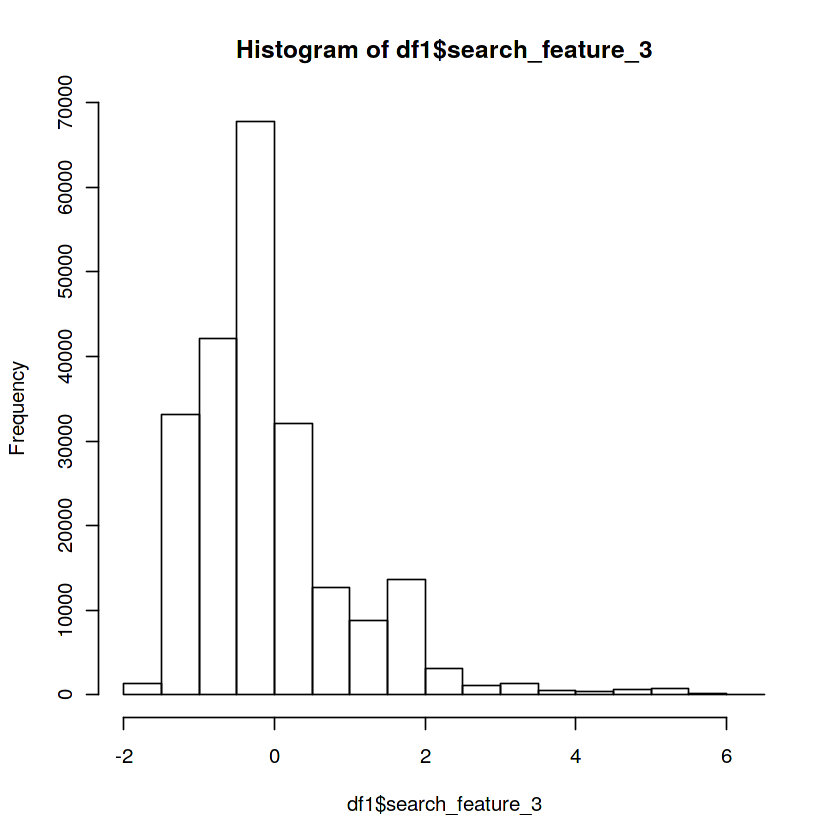

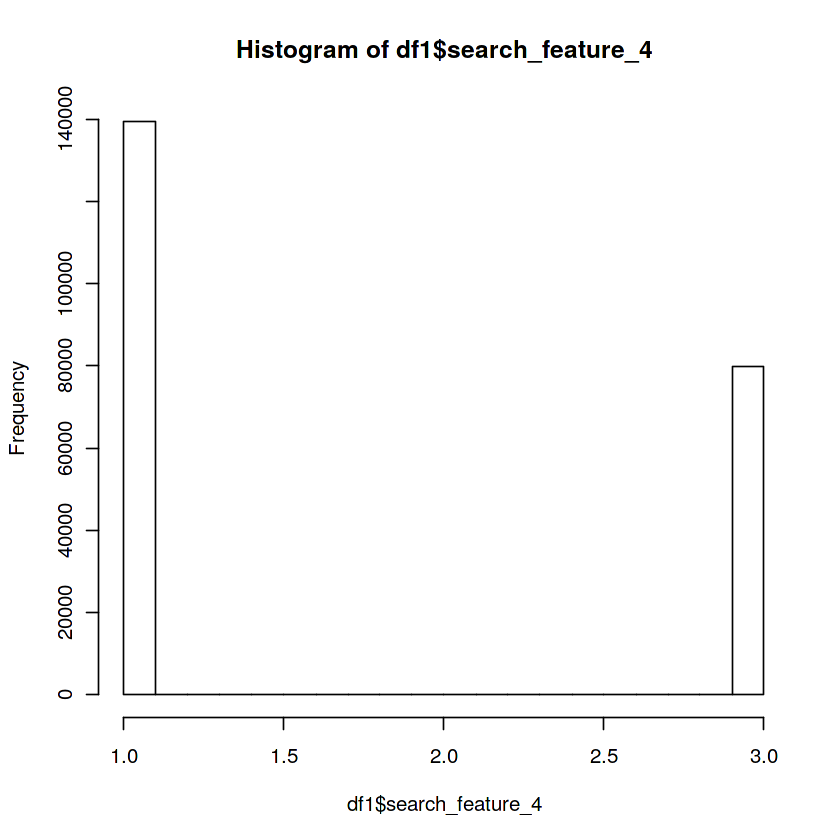

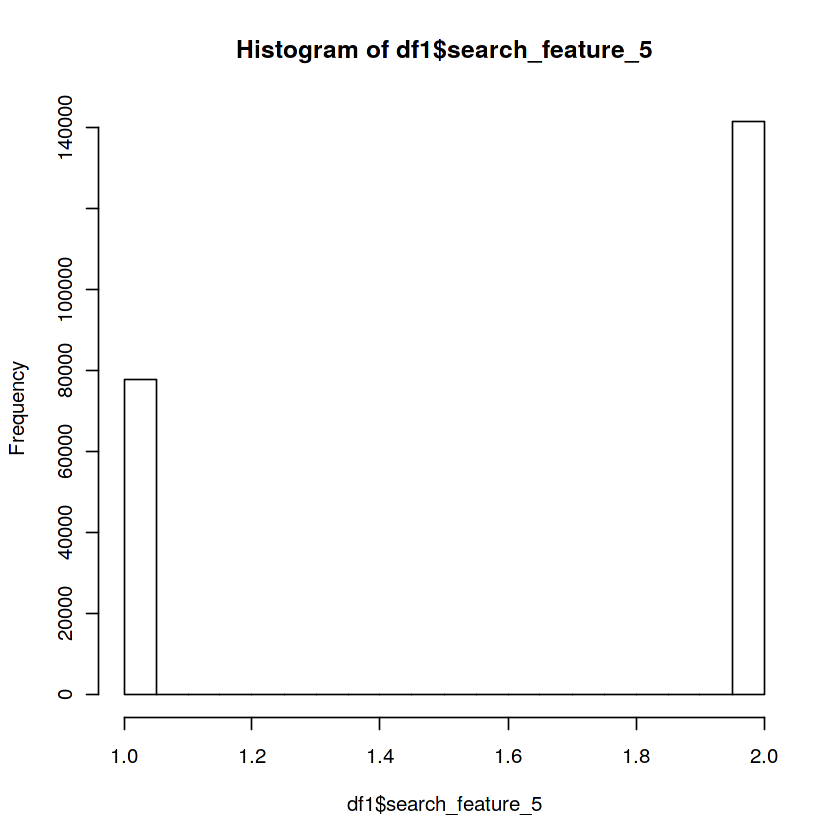

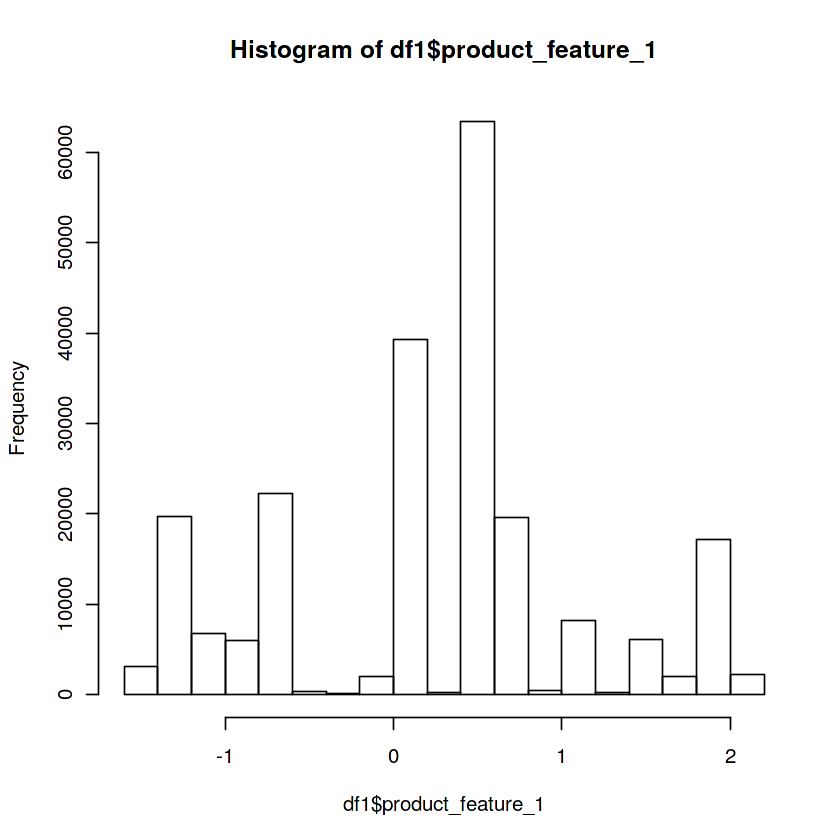

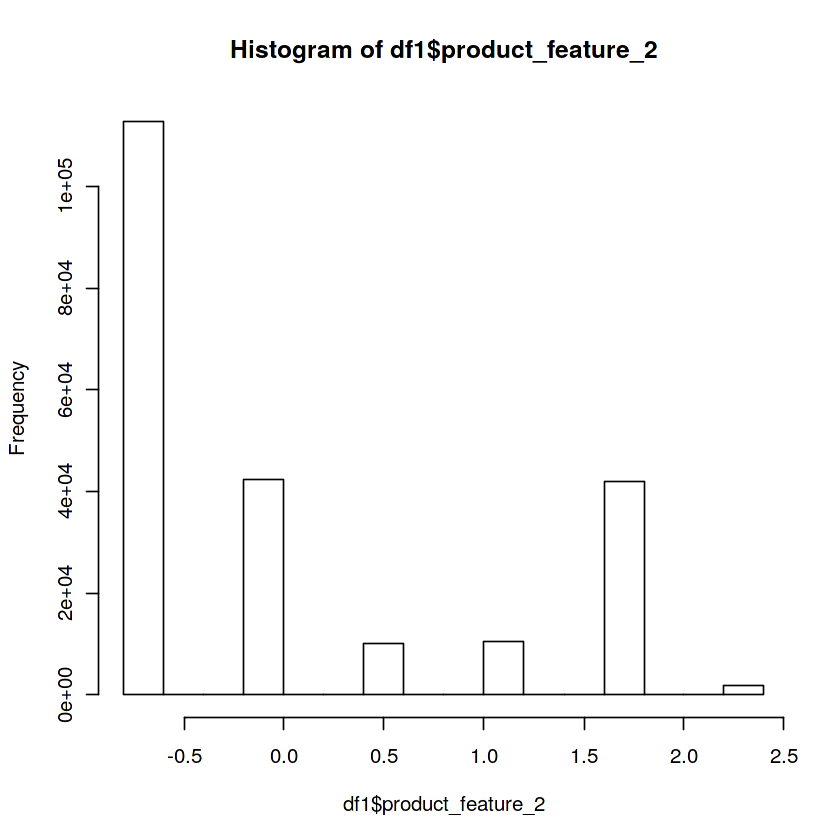

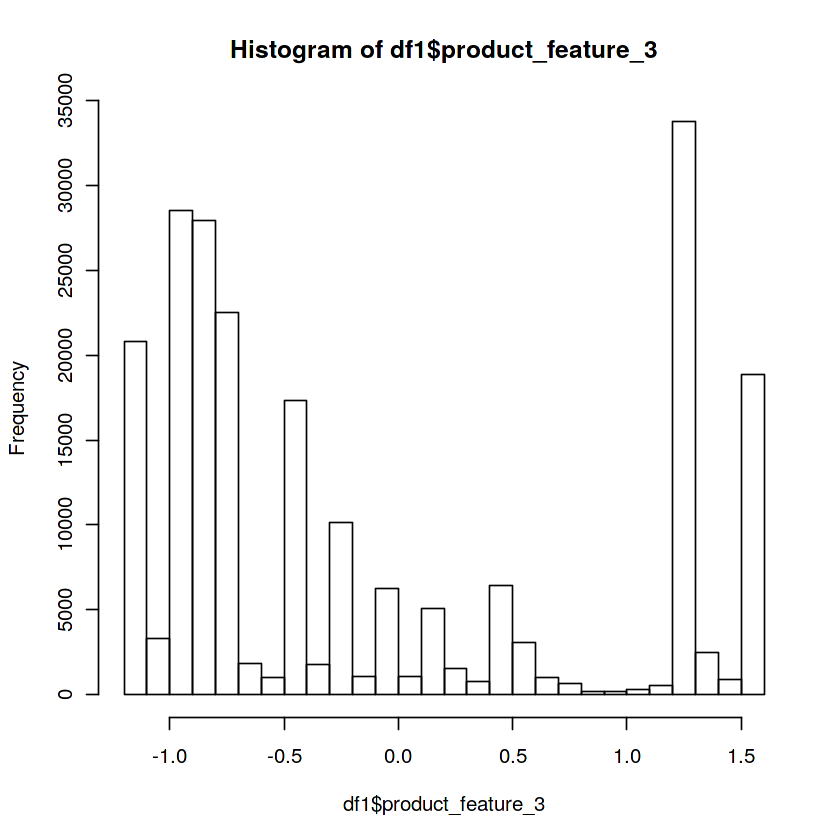

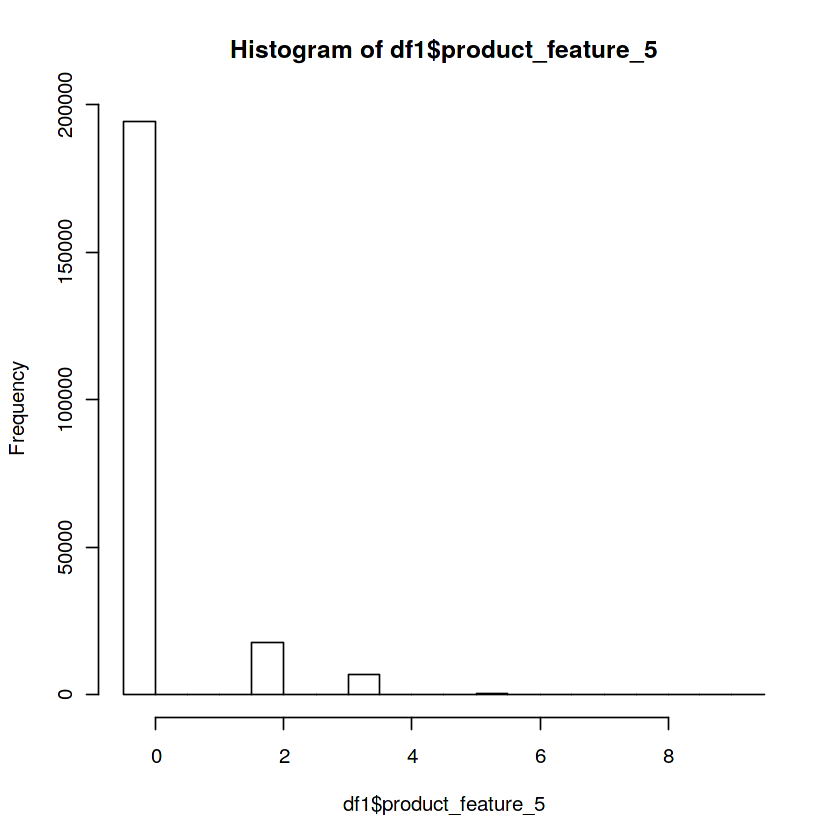

In [32]:
colnames <- grep("_feature", names(df1), value = TRUE)
colnames <- colnames[-9]
df1 <- drop_na(df1)

hist(df1$search_feature_1)

# Histograms and density lines
par(mfrow=c(3, 3))
par(mar=c(0,0,0,0))
dev.off()
par()

hist(df1$search_feature_1)
hist(df1$search_feature_2)
hist(df1$search_feature_3)
hist(df1$search_feature_4)
hist(df1$search_feature_5)
hist(df1$product_feature_1)
hist(df1$product_feature_2)
hist(df1$product_feature_3)
hist(df1$product_feature_5)
hist(df1$product_feature_6)
hist(df1$product_feature_7)


for (col in colnames) {
    hist(df1[,col], xlim=c(0, 20), breaks=10, 
         main=col, probability=TRUE, col="gray", border="white")
    d <- density(df1[,col])
    lines(d, col="red")
}

In [19]:
summary(df1)

     row_id        search_date    search_feature_1  search_feature_2 
 Min.   :     0   Min.   : 0.00   Min.   :-1.1673   Min.   :-1.1217  
 1st Qu.: 75948   1st Qu.:15.00   1st Qu.:-1.1673   1st Qu.:-0.6077  
 Median :151896   Median :25.00   Median :-0.1109   Median :-0.3178  
 Mean   :151896   Mean   :23.82   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:227844   3rd Qu.:33.00   3rd Qu.: 0.9454   3rd Qu.: 0.1303  
 Max.   :303792   Max.   :42.00   Max.   : 1.4736   Max.   : 5.9947  
                                                                     
 search_feature_3   search_feature_4 search_feature_5 product_feature_1 
 Min.   :-1.72944   Min.   :1.000    Min.   :1.00     Min.   :-1.54199  
 1st Qu.:-0.53217   1st Qu.:1.000    1st Qu.:1.00     1st Qu.:-1.11145  
 Median :-0.05326   Median :1.000    Median :2.00     Median : 0.01869  
 Mean   : 0.00000   Mean   :1.704    Mean   :1.65     Mean   : 0.00000  
 3rd Qu.: 0.42565   3rd Qu.:3.000    3rd Qu.:2.00     3rd Qu.: 0.55686  
 M